In [1]:
import pandas as pd
import numpy as np
import re
import os
from tkinter import filedialog, Tk
from tkinter.messagebox import showinfo
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
# [1] Multipple Files
class PCHtoCSVConverter:
    def __init__(self):
        self.df = pd.DataFrame()
        self.node_data = {}
        self.frequencies = set()
        self.file_count = 0

    def read_pch_files(self, pch_file_paths):
        numeric_pattern = re.compile(r"[-+]?\d*\.\d+[Ee][+-]?\d+|[-+]?\d+")
        
        for file_idx, pch_file_path in enumerate(pch_file_paths, 1):
            with open(pch_file_path, 'r') as pch_file:
                current_node = None
                trans_mag, rot_mag, trans_phase, rot_phase = [], [], [], []
                line_counter = 0
                filename = os.path.splitext(os.path.basename(pch_file_path))[0]
                file_tag = f"File_{filename}"  # e.g., "File_analysis1"

                for line in pch_file:
                    line = line.strip()
                    
                    if line.startswith('$FREQUENCY'):
                        match = re.search(numeric_pattern, line)
                        if match:
                            self.current_frequency = float(match.group())
                            self.frequencies.add(self.current_frequency)
                            line_counter = 0
                    
                    elif line and not line.startswith(('$', '-')):
                        if not line.startswith('-CONT-'):
                            if current_node is not None and trans_mag:
                                self._store_node_data(current_node, trans_mag, rot_mag, 
                                                    trans_phase, rot_phase, file_tag)
                            
                            parts = line.split()
                            current_node = int(parts[0])
                            trans_mag = [float(x) for x in parts[2:5]]
                            rot_mag, trans_phase, rot_phase = [], [], []
                            line_counter = 1
                    
                    elif line.startswith('-CONT-'):
                        line_counter += 1
                        parts = line.split()
                        if len(parts) >= 4:
                            data_values = [float(x) for x in parts[1:4]]
                            
                            if line_counter == 2:
                                rot_mag = data_values
                            elif line_counter == 3:
                                trans_phase = data_values
                            elif line_counter == 4:
                                rot_phase = data_values
                                line_counter = 0
                
                if current_node is not None and trans_mag:
                    self._store_node_data(current_node, trans_mag, rot_mag, 
                                        trans_phase, rot_phase, file_tag)

    def _store_node_data(self, node, trans_mag, rot_mag, trans_phase, rot_phase, file_tag):
        key = f"Node_{node}"
        
        components = {
            'tm': (trans_mag, ['x', 'y', 'z']),  # Translational Magnitude
            'rm': (rot_mag, ['x', 'y', 'z']),    # Rotational Magnitude
            'tp': (trans_phase, ['x', 'y', 'z']), # Translational Phase
            'rp': (rot_phase, ['x', 'y', 'z'])    # Rotational Phase
        }
        
        for comp_type, (data, axes) in components.items():
            for axis, value in zip(axes, data):
                col_name = f"{key}_{comp_type}_{axis}_{file_tag}"  # Updated naming
                if len(data) >= 3:
                    self.node_data.setdefault(col_name, {})[self.current_frequency] = value
                else:
                    self.node_data.setdefault(col_name, {})[self.current_frequency] = np.nan

    def to_dataframe(self):
        temp_df = pd.DataFrame.from_dict(self.node_data, orient='index').T
        temp_df.index.name = 'Frequency'
        return temp_df.sort_index(axis=1).reset_index()

    def process_files(self):
        root = Tk()
        root.withdraw()
        pch_file_paths = filedialog.askopenfilenames(
            title="Select PCH Files",
            filetypes=[("Punch files", "*.pch"), ("All files", "*.*")]
        )
        
        if not pch_file_paths:
            print("No files selected")
            return
        
        output_dir = os.path.dirname(pch_file_paths[0])
        output_path = os.path.join(output_dir, "combined_pch_data.csv")
        
        self.read_pch_files(pch_file_paths)
        self.df = self.to_dataframe()
        self.df.to_csv(output_path, index=False, float_format='%.6E')
        
        # Show summary
        unique_nodes = len({k.split('_')[1] for k in self.node_data.keys()})
        showinfo(
            "Conversion Complete",
            f"Combined {len(pch_file_paths)} files into:\n{output_path}\n"
            f"Total frequencies: {len(self.frequencies)}\n"
            f"Total nodes: {unique_nodes}\n"
            f"Total columns: {len(self.df.columns)-1}"  # Exclude Frequency column
        )

if __name__ == "__main__":
    converter = PCHtoCSVConverter()
    converter.process_files()

In [ ]:
# [2] Multipple Files
class PCHtoCSVConverter:
    def __init__(self):
        self.df = pd.DataFrame()
        self.node_data = {}
        self.frequencies = set()

    def read_pch_files(self, pch_file_paths):
        numeric_pattern = re.compile(r"[-+]?\d*\.\d+[Ee][+-]?\d+|[-+]?\d+")
        
        for file_idx, pch_file_path in enumerate(pch_file_paths, 1):  # 1-based index
            with open(pch_file_path, 'r') as pch_file:
                current_node = None
                trans_mag, rot_mag, trans_phase, rot_phase = [], [], [], []
                line_counter = 0
                file_tag = f"File_{file_idx}"  # e.g., "File_1", "File_2"

                for line in pch_file:
                    line = line.strip()
                    
                    if line.startswith('$FREQUENCY'):
                        match = re.search(numeric_pattern, line)
                        if match:
                            self.current_frequency = float(match.group())
                            self.frequencies.add(self.current_frequency)
                            line_counter = 0
                    
                    elif line and not line.startswith(('$', '-')):
                        if not line.startswith('-CONT-'):
                            if current_node is not None and trans_mag:
                                self._store_node_data(current_node, trans_mag, rot_mag, 
                                                    trans_phase, rot_phase, file_tag)
                            
                            parts = line.split()
                            current_node = int(parts[0])
                            trans_mag = [float(x) for x in parts[2:5]]
                            rot_mag, trans_phase, rot_phase = [], [], []
                            line_counter = 1
                    
                    elif line.startswith('-CONT-'):
                        line_counter += 1
                        parts = line.split()
                        if len(parts) >= 4:
                            data_values = [float(x) for x in parts[1:4]]
                            
                            if line_counter == 2:
                                rot_mag = data_values
                            elif line_counter == 3:
                                trans_phase = data_values
                            elif line_counter == 4:
                                rot_phase = data_values
                                line_counter = 0
                
                if current_node is not None and trans_mag:
                    self._store_node_data(current_node, trans_mag, rot_mag, 
                                        trans_phase, rot_phase, file_tag)

    def _store_node_data(self, node, trans_mag, rot_mag, trans_phase, rot_phase, file_tag):
        key = f"Node_{node}"
        
        components = {
            'tm': (trans_mag, ['x', 'y', 'z']),  # Translational Magnitude
            'rm': (rot_mag, ['x', 'y', 'z']),    # Rotational Magnitude
            'tp': (trans_phase, ['x', 'y', 'z']), # Translational Phase
            'rp': (rot_phase, ['x', 'y', 'z'])    # Rotational Phase
        }
        
        for comp_type, (data, axes) in components.items():
            for axis, value in zip(axes, data):
                col_name = f"{key}_{comp_type}_{axis}_{file_tag}"  # e.g., Node_10987_rm_x_File_1
                if len(data) >= 3:
                    self.node_data.setdefault(col_name, {})[self.current_frequency] = value
                else:
                    self.node_data.setdefault(col_name, {})[self.current_frequency] = np.nan

    def to_dataframe(self):
        temp_df = pd.DataFrame.from_dict(self.node_data, orient='index').T
        temp_df.index.name = 'Frequency'
        return temp_df.sort_index(axis=1).reset_index()

    def process_files(self):
        root = Tk()
        root.withdraw()
        pch_file_paths = filedialog.askopenfilenames(
            title="Select PCH Files",
            filetypes=[("Punch files", "*.pch"), ("All files", "*.*")]
        )
        
        if not pch_file_paths:
            print("No files selected")
            return
        
        output_dir = os.path.dirname(pch_file_paths[0])
        output_path = os.path.join(output_dir, "combined_pch_data.csv")
        
        self.read_pch_files(pch_file_paths)
        self.df = self.to_dataframe()
        self.df.to_csv(output_path, index=False, float_format='%.6E')
        
        # Show summary
        unique_nodes = len({k.split('_')[1] for k in self.node_data.keys()})
        showinfo(
            "Conversion Complete",
            f"Combined {len(pch_file_paths)} files into:\n{output_path}\n"
            f"Total frequencies: {len(self.frequencies)}\n"
            f"Total nodes: {unique_nodes}\n"
            f"Columns follow format: Node_<ID>_<Type>_<Axis>_File_<Sequence>"
        )

if __name__ == "__main__":
    converter = PCHtoCSVConverter()
    converter.process_files()

In [ ]:
df = pd.read_csv(r"E:\Punch File\combined_pch_data.csv")
# list(df.columns)
df

In [2]:
import pandas as pd
import numpy as np
import re
import os
from tkinter import Tk, filedialog, messagebox, simpledialog, Button, Label, Frame

class PCHtoCSVConverter:
    def __init__(self, master):
        self.master = master
        master.title("PCH File Processor")
        
        self.df = pd.DataFrame()
        self.node_data = {}
        self.frequencies = set()
        self.loaded_files = []
        
        # GUI Setup
        self.frame = Frame(master)
        self.frame.pack(padx=10, pady=10)
        
        Label(self.frame, text="PCH File Processor", font=('Arial', 14)).grid(row=0, columnspan=2)
        
        Button(self.frame, text="1. Add PCH Files", command=self.add_files, width=20).grid(row=1, column=0, pady=5)
        Button(self.frame, text="2. Show Current Data", command=self.show_data, width=20).grid(row=1, column=1, pady=5)
        Button(self.frame, text="3. Export to CSV", command=self.export_csv, width=20).grid(row=2, column=0, pady=5)
        Button(self.frame, text="4. Clear All Data", command=self.clear_data, width=20).grid(row=2, column=1, pady=5)
        Button(self.frame, text="5. Exit", command=master.quit, width=20).grid(row=3, columnspan=2, pady=5)
        
        self.status_label = Label(self.frame, text="No files loaded", fg="blue")
        self.status_label.grid(row=4, columnspan=2)

    def add_files(self):
        file_paths = filedialog.askopenfilenames(
            title="Select PCH Files",
            filetypes=[("Punch files", "*.pch"), ("All files", "*.*")]
        )
        
        if not file_paths:
            return
        
        new_files = [f for f in file_paths if f not in self.loaded_files]
        
        if not new_files:
            messagebox.showinfo("Info", "Selected files are already loaded")
            return
        
        for file_idx, file_path in enumerate(new_files, len(self.loaded_files)+1):
            try:
                self._read_single_pch(file_path, file_idx)
                self.loaded_files.append(file_path)
            except Exception as e:
                messagebox.showerror("Error", f"Failed to process {os.path.basename(file_path)}:\n{str(e)}")
        
        self.status_label.config(text=f"Loaded {len(self.loaded_files)} files | {len(self.frequencies)} frequencies")
        messagebox.showinfo("Success", f"Added {len(new_files)} new file(s)")

    def _read_single_pch(self, file_path, file_idx):
        numeric_pattern = re.compile(r"[-+]?\d*\.\d+[Ee][+-]?\d+|[-+]?\d+")
        file_tag = f"File_{file_idx}"
        
        with open(file_path, 'r') as pch_file:
            current_node = None
            trans_mag = rot_mag = trans_phase = rot_phase = []
            line_counter = 0
            
            for line in pch_file:
                line = line.strip()
                
                if line.startswith('$FREQUENCY'):
                    match = re.search(numeric_pattern, line)
                    if match:
                        self.current_frequency = float(match.group())
                        self.frequencies.add(self.current_frequency)
                        line_counter = 0
                
                elif line and not line.startswith(('$', '-')):
                    if not line.startswith('-CONT-'):
                        if current_node is not None and trans_mag:
                            self._store_node_data(current_node, trans_mag, rot_mag, 
                                                trans_phase, rot_phase, file_tag)
                        
                        parts = line.split()
                        current_node = int(parts[0])
                        trans_mag = [float(x) for x in parts[2:5]]
                        rot_mag = trans_phase = rot_phase = []
                        line_counter = 1
                
                elif line.startswith('-CONT-'):
                    line_counter += 1
                    parts = line.split()
                    if len(parts) >= 4:
                        data_values = [float(x) for x in parts[1:4]]
                        
                        if line_counter == 2:
                            rot_mag = data_values
                        elif line_counter == 3:
                            trans_phase = data_values
                        elif line_counter == 4:
                            rot_phase = data_values
                            line_counter = 0
            
            if current_node is not None and trans_mag:
                self._store_node_data(current_node, trans_mag, rot_mag, 
                                    trans_phase, rot_phase, file_tag)

    def _store_node_data(self, node, trans_mag, rot_mag, trans_phase, rot_phase, file_tag):
        key = f"Node_{node}"
        
        components = {
            'tm': (trans_mag, ['x', 'y', 'z']),
            'rm': (rot_mag, ['x', 'y', 'z']),
            'tp': (trans_phase, ['x', 'y', 'z']),
            'rp': (rot_phase, ['x', 'y', 'z'])
        }
        
        for comp_type, (data, axes) in components.items():
            for axis, value in zip(axes, data):
                col_name = f"{key}_{comp_type}_{axis}_{file_tag}"
                if len(data) >= 3:
                    self.node_data.setdefault(col_name, {})[self.current_frequency] = value
                else:
                    self.node_data.setdefault(col_name, {})[self.current_frequency] = np.nan

    def to_dataframe(self):
        if not self.node_data:
            return pd.DataFrame()
        
        temp_df = pd.DataFrame.from_dict(self.node_data, orient='index').T
        temp_df.index.name = 'Frequency'
        return temp_df.sort_index(axis=1).reset_index()

    def show_data(self):
        self.df = self.to_dataframe()
        
        if self.df.empty:
            messagebox.showinfo("Data Preview", "No data available")
            return
        
        # Create preview window
        preview = Tk()
        preview.title(f"Data Preview ({len(self.df.columns)-1} columns)")
        
        # Show basic info
        Label(preview, text=f"Loaded Files: {len(self.loaded_files)}").pack()
        Label(preview, text=f"Frequencies: {len(self.frequencies)}").pack()
        Label(preview, text=f"Columns: {len(self.df.columns)-1}").pack()
        
        # Show first 5 rows
        from tkinter import scrolledtext
        txt = scrolledtext.ScrolledText(preview, width=120, height=20)
        txt.pack()
        txt.insert('end', self.df.head().to_string())
        txt.config(state='disabled')

    def export_csv(self):
        if not self.node_data:
            messagebox.showerror("Error", "No data to export")
            return
        
        output_path = filedialog.asksaveasfilename(
            defaultextension=".csv",
            filetypes=[("CSV files", "*.csv")],
            title="Save Combined Data As"
        )
        
        if not output_path:
            return
        
        self.df = self.to_dataframe()
        self.df.to_csv(output_path, index=False, float_format='%.6E')
        messagebox.showinfo("Success", f"Data exported to:\n{output_path}")

    def clear_data(self):
        if messagebox.askyesno("Confirm", "Clear all loaded data?"):
            self.df = pd.DataFrame()
            self.node_data = {}
            self.frequencies = set()
            self.loaded_files = []
            self.status_label.config(text="No files loaded")
            messagebox.showinfo("Cleared", "All data has been reset")

if __name__ == "__main__":
    root = Tk()
    app = PCHtoCSVConverter(root)
    root.mainloop()

In [3]:
df = pd.read_csv(r"E:\Punch File\MultipleFiles_test_1.csv")#,usecols=['column1', 'column2'])
# list(df.columns)
df

,Frequency,Node_10987_rm_x_File_1,Node_10987_rm_x_File_2,Node_10987_rm_x_File_3,Node_10987_rm_x_File_4,Node_10987_rm_x_File_5,Node_10987_rm_y_File_1,Node_10987_rm_y_File_2,Node_10987_rm_y_File_3,Node_10987_rm_y_File_4,...,Node_13782_tp_y_File_1,Node_13782_tp_y_File_2,Node_13782_tp_y_File_3,Node_13782_tp_y_File_4,Node_13782_tp_y_File_5,Node_13782_tp_z_File_1,Node_13782_tp_z_File_2,Node_13782_tp_z_File_3,Node_13782_tp_z_File_4,Node_13782_tp_z_File_5
0,1.0,0.000136,0.000136,0.000136,0.000136,0.000136,0.000008,0.000008,0.000008,0.000008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,0.000169,0.000169,0.000169,0.000169,0.000169,0.000007,0.000007,0.000007,0.000007,...,0.143036,0.143036,0.143036,0.143036,0.143036,0.106418,0.106418,0.106418,0.106418,0.106418
2,5.0,0.000252,0.000252,0.000252,0.000252,0.000252,0.000008,0.000008,0.000008,0.000008,...,0.014904,0.014904,0.014904,0.014904,0.014904,359.733400,359.733400,359.733400,359.733400,359.733400
3,7.0,0.000375,0.000375,0.000375,0.000375,0.000375,0.000008,0.000008,0.000008,0.000008,...,0.005560,0.005560,0.005560,0.005560,0.005560,359.400100,359.400100,359.400100,359.400100,359.400100
4,9.0,0.000541,0.000541,0.000541,0.000541,0.000541,0.000009,0.000009,0.000009,0.000009,...,359.991500,359.991500,359.991500,359.991500,359.991500,359.095200,359.095200,359.095200,359.095200,359.095200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,393.0,1.394929,1.394929,1.394929,1.394929,1.394929,0.047478,0.047478,0.047478,0.047478,...,164.855000,164.855000,164.855000,164.855000,164.855000,169.467500,169.467500,169.467500,169.467500,169.467500
197,395.0,1.408924,1.408924,1.408924,1.408924,1.408924,0.063393,0.063393,0.063393,0.063393,...,162.770000,162.770000,162.770000,162.770000,162.770000,167.870100,167.870100,167.870100,167.870100,167.870100
198,397.0,1.417846,1.417846,1.417846,1.417846,1.417846,0.084104,0.084104,0.084104,0.084104,...,158.907700,158.907700,158.907700,158.907700,158.907700,164.913400,164.913400,164.913400,164.913400,164.913400
199,399.0,1.406647,1.406647,1.406647,1.406647,1.406647,0.109382,0.109382,0.109382,0.109382,...,152.687700,152.687700,152.687700,152.687700,152.687700,160.147000,160.147000,160.147000,160.147000,160.147000


## Plot setup

## Data Selection Based On Requirment

In [7]:
# Get user input for node range
start_node = int(input("Please enter the start node (default=11000): ") or 11000)
end_node = int(input("Please enter the end node (default=14000): ") or 12000)

# Get user input for measurement types
measurement_input = input("Enter measurement types to plot (comma separated, e.g., 'tm,rm,rp', default=tm): ") or 'tm'
measurement_types = [m.strip() for m in measurement_input.split(',')]

# Filter columns based on node numbers and measurement types
selected_columns = ['Frequency']  # Always include Frequency column
for col in df.columns:
    if 'Node_' in col:
        node_num = int(col.split('_')[1])  # Extract node number
        if start_node <= node_num <= end_node:
            # Check if column matches any of the requested measurement types
            for mtype in measurement_types:
                if f'_{mtype}_' in col:
                    selected_columns.append(col)                                                         
                    break

# Create filtered dataframe
filtered_df = df[selected_columns]


Please enter the start node (default=11000):  11000
Please enter the end node (default=14000):  12000
Enter measurement types to plot (comma separated, e.g., 'tm,rm,rp', default=tm):  tm


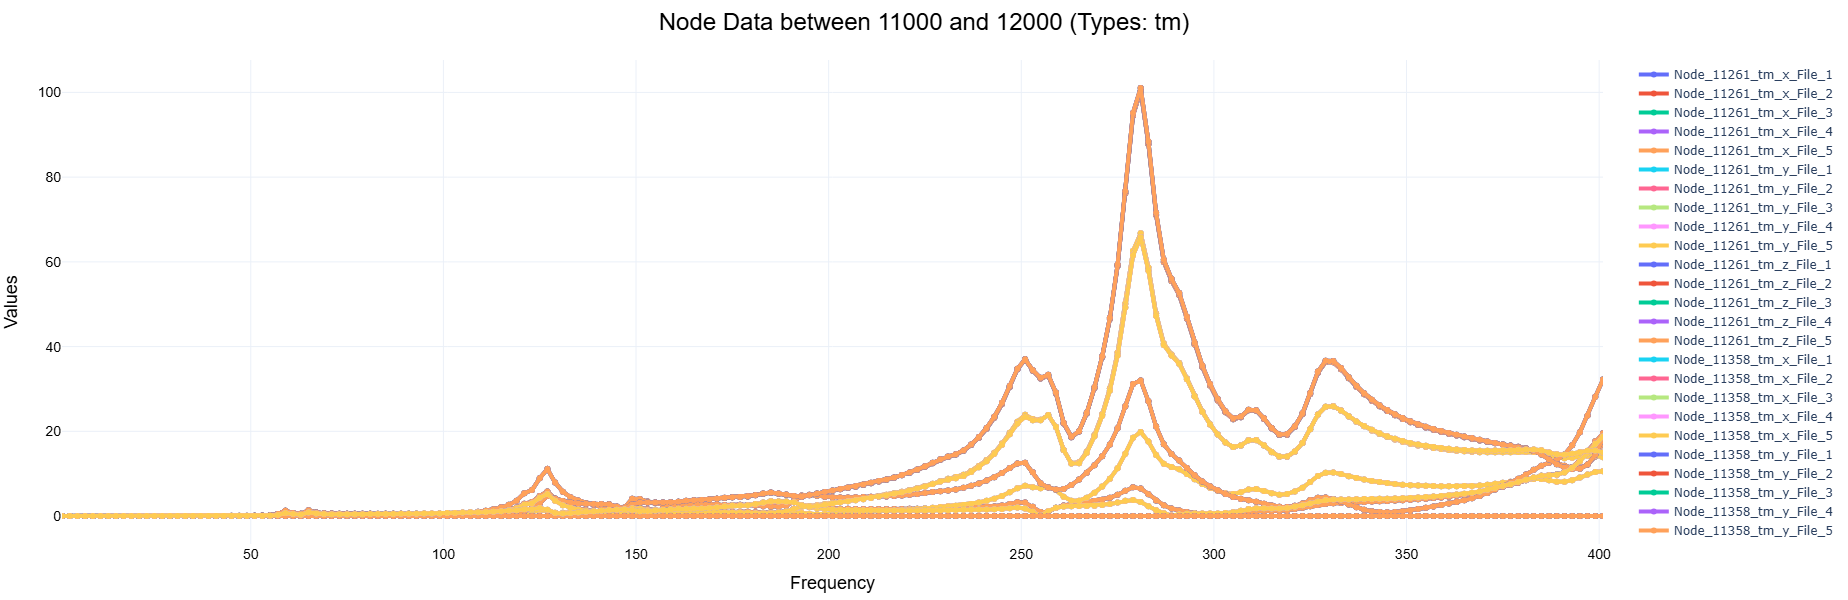

In [8]:
import plotly.graph_objects as go

# Create filtered dataframe
# filtered_df = df[selected_columns]

# Initialize figure
fig = go.Figure()

# Define PowerPoint styling (unchanged)
standard_linewidth = 4
title_font = dict(family="Arial", size=24, color="black")
axis_label_font = dict(family="Arial", size=18, color="black")
axis_tick_font = dict(family="Arial", size=14, color="black")
standard_margin = dict(l=10, r=10, t=60, b=40)

# Add traces for each column
for col in filtered_df.columns:
    if col != 'Frequency':
        parts = col.split('_')
        node_number = parts[1]  # e.g., "11261"
        file_name = parts[-1]   # e.g., "1"
        if  parts[3] == "x" or 'y'or 'z':
            file_axis = parts[3]   # e.g., "1" -------------------------------------------------------------------- Node_10987_rm_x_File_1
        
        else:
            file_axis = ""
            
        # Check if 'Axis' is in the column name (e.g., "Node_11261_Type_X_Axis_1")
        hover_template_parts = [
            f'<b>Node:</b> {node_number}<br>',
            f'<b>File:</b> {file_name}<br>',
            f'<b>Axis:</b> {file_axis}<br>',
            
            '<b>Frequency:</b> %{x}<br>',
            '<b>Amplitude:</b> %{y}<br>',
            '<extra></extra>'
                                ]
        
        # Only insert Axis if column name contains "Axis"
        if 'Axis' in col:
            axis_value = parts[3]  # Assuming format: Node_XX_Type_XX_Axis_XX_File
            hover_template_parts.insert(1, f'<b>Axis:</b> {axis_value}<br>')
        
        fig.add_trace(go.Scatter(
            x=filtered_df['Frequency'],
            y=filtered_df[col],
            mode='lines+markers',
            line=dict(width=standard_linewidth),
            name=col,
            hovertemplate=''.join(hover_template_parts)  # Combine parts into one string
        ))

# Update layout (unchanged)
fig.update_layout(
    title={
        'text': f'Node Data between {start_node} and {end_node} (Types: {", ".join(measurement_types)})',
        'font': title_font,
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis=dict(
        title='Frequency',
        title_font=axis_label_font,
        tickfont=axis_tick_font,
        range=[filtered_df['Frequency'].min(), filtered_df['Frequency'].max()]
    ),
    yaxis=dict(
        title='Values',
        title_font=axis_label_font,
        tickfont=axis_tick_font
    ),
    legend_title_font=axis_label_font,
    margin=standard_margin,
    width=900,
    height=600,
    template='plotly_white'
)

fig.show()


In [10]:
from scipy.signal import find_peaks

def Find_Max_Location(Data):
    # Ensure Data is a copy of the original DataFrame
    Data = Data.copy()
    
    # Calculate the maximum value across all magnitude columns (ignoring "Frequency [Hz]")
    Data["Max_Peaks"] = Data.iloc[:, 1:].max(axis=1)
    
    # Extract the relevant column for peak detection
    rms = Data["Max_Peaks"].values
    
    # Find peaks in the selected magnitude curve
    peaks, properties = find_peaks(
        rms,
        height=0.1 * np.max(rms),  # Minimum peak height (10% of max)
        distance=1,  # Minimum distance between peaks (in data points)
        prominence=0.5  # Minimum prominence of peaks
    )
    frequency = Data.get("Frequency [Hz]", Data.get("Frequency")).values  # Convert to NumPy array for proper indexing
    # frequency = Data["Frequency [Hz]" or "Frequency"].values  # Convert to NumPy array for proper indexing
    
    # Display only frequency and corresponding peak value
    print("\nPeak Frequencies & Amplitudes:")
    for i, peak in enumerate(peaks):
        print(f"Frequency = {frequency[peak]} Hz, Peak Value = {rms[peak]}")

# Ensure you are working with a copy of the subset to avoid SettingWithCopyWarning
# data = HG.loc[:, ["Frequency [Hz]", "MAG | X-Trans", "MAG | Y-Trans", "MAG | Z-Trans"]].copy()
Find_Max_Location(filtered_df)


Peak Frequencies & Amplitudes:
Frequency = 127.0 Hz, Peak Value = 11.12572
Frequency = 251.0 Hz, Peak Value = 37.01849
Frequency = 257.0 Hz, Peak Value = 33.32901
Frequency = 281.0 Hz, Peak Value = 101.0566
Frequency = 309.0 Hz, Peak Value = 25.10504
Frequency = 329.0 Hz, Peak Value = 36.63212
